In [1]:
import pandas as pd
import numpy as np
import catboost
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse

In [2]:
from catboost.utils import get_gpu_device_count 
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [3]:
df = pd.read_csv('pharmacy_tx.csv') 

In [4]:
df[['type', 'drug']]=df['drug'].str.split(' ', expand = True)
df['tx_date'] = pd.to_datetime(df['tx_date'])
df = df.fillna('NA')

In [5]:
df

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,type
0,2022-01-02,Pharmacy #6,G99.93,tanoclolol,725700,1UQC,NA,False,13.39,branded
1,2022-01-02,Pharmacy #42,U60.52,oxasoted,664344,NA,52H8KH0F83K,False,7.02,branded
2,2022-01-02,Pharmacy #37,Q85.91,cupitelol,725700,1UQC,NA,False,13.39,branded
3,2022-01-02,Pharmacy #30,U60.52,oxasoted,571569,KB38N,6BYJBW,False,10.84,generic
4,2022-01-02,Pharmacy #18,N55.01,mamate,664344,NA,ZX2QUWR,False,47.00,branded
...,...,...,...,...,...,...,...,...,...,...
13910239,2022-12-30,Pharmacy #42,U27.71,colifunene,322463,NA,HO8HUGL,True,0.00,branded
13910240,2022-12-30,Pharmacy #45,N59.44,tafistitrisin,664344,NA,TFZOR5R49,False,6.28,generic
13910241,2022-12-30,Pharmacy #54,W50.87,tanoclolol,691847,N098KI,6SP1DG,False,6.94,generic
13910242,2022-12-30,Pharmacy #0,I68.27,prazinib,96934,S76J7V6,NA,False,13.93,branded


In [6]:
X = pd.concat([(df['tx_date'].astype('int') - df['tx_date'].astype('int')[0])/86400000000000, df.drop(columns=['tx_date','rejected','patient_pay'])], axis=1)
#X = pd.concat([df['tx_date'].astype('int').astype('float'), df.drop(columns=['tx_date','rejected','patient_pay'])], axis=1)

In [7]:
y = df[['rejected', 'patient_pay']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
X

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,type
0,0.0,Pharmacy #6,G99.93,tanoclolol,725700,1UQC,NA,branded
1,0.0,Pharmacy #42,U60.52,oxasoted,664344,NA,52H8KH0F83K,branded
2,0.0,Pharmacy #37,Q85.91,cupitelol,725700,1UQC,NA,branded
3,0.0,Pharmacy #30,U60.52,oxasoted,571569,KB38N,6BYJBW,generic
4,0.0,Pharmacy #18,N55.01,mamate,664344,NA,ZX2QUWR,branded
...,...,...,...,...,...,...,...,...
13910239,362.0,Pharmacy #42,U27.71,colifunene,322463,NA,HO8HUGL,branded
13910240,362.0,Pharmacy #45,N59.44,tafistitrisin,664344,NA,TFZOR5R49,generic
13910241,362.0,Pharmacy #54,W50.87,tanoclolol,691847,N098KI,6SP1DG,generic
13910242,362.0,Pharmacy #0,I68.27,prazinib,96934,S76J7V6,NA,branded


In [10]:
cat_features = np.where(X_train.dtypes != float)[0]
patient_pay_train = catboost.Pool(data=X_train,label=y_train['patient_pay'],cat_features=cat_features)
rejected_train = catboost.Pool(data=X_train,label=y_train['rejected'],cat_features=cat_features)

In [12]:
reg = catboost.CatBoostRegressor(task_type='GPU')
cls = catboost.CatBoostClassifier(task_type='GPU')

In [13]:
reg.fit(patient_pay_train)
cls.fit(rejected_train)

Learning rate set to 0.136897
0:	learn: 37.1200655	total: 705ms	remaining: 11m 44s
1:	learn: 35.2180358	total: 1.39s	remaining: 11m 35s
2:	learn: 33.8387450	total: 1.98s	remaining: 10m 58s
3:	learn: 32.6370100	total: 2.69s	remaining: 11m 9s
4:	learn: 31.7976600	total: 3.26s	remaining: 10m 49s
5:	learn: 31.0807018	total: 3.98s	remaining: 10m 58s
6:	learn: 30.4996918	total: 4.66s	remaining: 11m 1s
7:	learn: 30.0534670	total: 5.5s	remaining: 11m 22s
8:	learn: 29.5447765	total: 6.39s	remaining: 11m 43s
9:	learn: 29.2597240	total: 7.45s	remaining: 12m 17s
10:	learn: 28.9930711	total: 8.29s	remaining: 12m 25s
11:	learn: 28.8048466	total: 9.51s	remaining: 13m 3s
12:	learn: 28.6176945	total: 10.5s	remaining: 13m 14s
13:	learn: 28.4864495	total: 11.3s	remaining: 13m 12s
14:	learn: 28.3822431	total: 12s	remaining: 13m 7s
15:	learn: 28.2019698	total: 12.8s	remaining: 13m 4s
16:	learn: 27.9990793	total: 13.4s	remaining: 12m 56s
17:	learn: 27.8473139	total: 14.1s	remaining: 12m 47s
18:	learn: 27.77

In [14]:
pred1 = reg.predict(X_test)
pred2 = cls.predict(X_test)

In [21]:
finalpred = pred1*np.invert(np.array(pred2))

TypeError: bad operand type for unary ~: 'str'

In [ ]:
mse(y_test.patient_pay, finalpred)

In [16]:
featureimportance = pd.DataFrame({'CatBoostRegressor':reg.feature_importances_, 'CatBoostClassifier':cls.feature_importances_}, index=X.columns.values)

<AxesSubplot:>

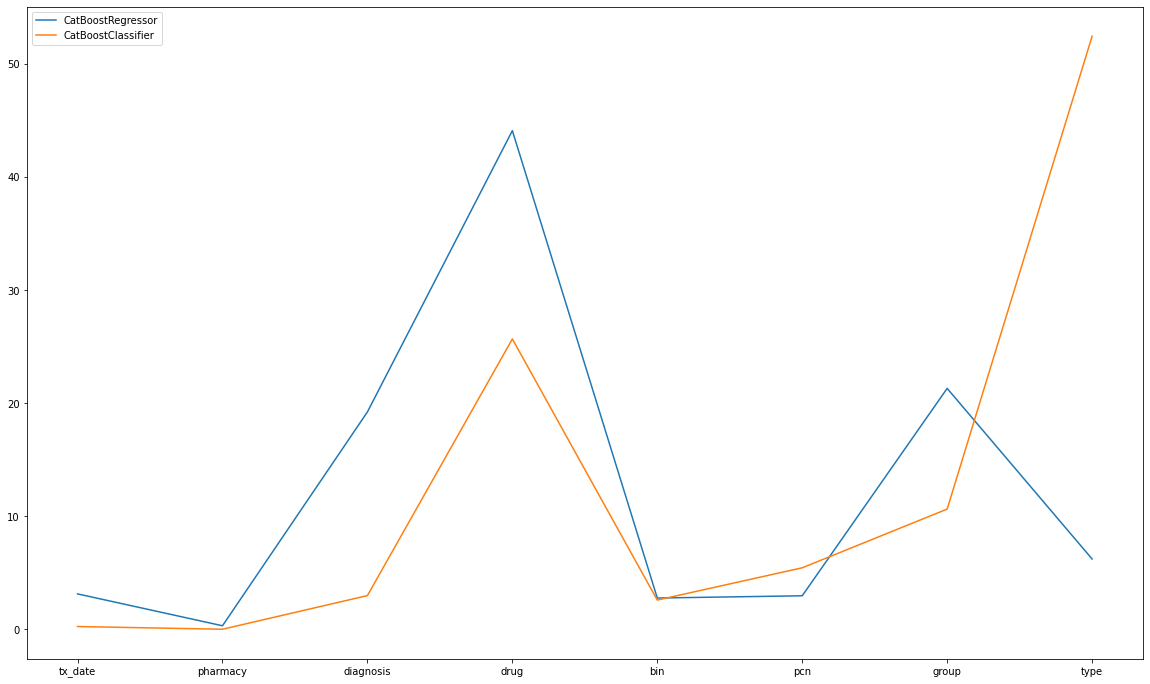

In [17]:
featureimportance.plot(figsize=(20,12))